In [46]:
import pandas as pd
import sklearn.ensemble
import sklearn.linear_model
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from time import time

# Data exploration

We will use the house appliances energy data (http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) provided by Luis Candanedo from University of Mons. This data consists of the energy consumption by the appliances of a house in Stambruges, Belgium measured every 10 minutes from 1/11/2016 to 5/27/2016

A brief description of the features is as follows, for more details, reader should refer to the link above and the references on that page

lights: energy use of light fixtures in the house in Wh 

Ti: Temperature in different areas in the house such as kitchen, laundry...

RH_i: Humidity in different areas in the house

T_out: Temperature outside 

RH_out: Humidity outside 

Press_mm_hg, Wind speed, Visibility, Tdewpoint: the weather condition outside, as their names suggest

rv1,rv2: random variables added by data provider for the purpose to filter useless features, we will not use them

In [2]:
data=pd.read_csv("energydata_complete.csv")
data['date']=data['date'].apply(lambda dt: datetime.strptime(dt,"%Y-%m-%d %H:%M:%S"))

From the date feature, we derive two features, corresponding to the data point's time in a day (measured by minutes passed after 0 am) and which of the day it is in a week (represented by 0,1...,6).

In [3]:
data['timeofday']=pd.Series([i.hour*60+i.minute for i in data['date']])
data['weekday']=pd.Series([i.weekday() for i in data['date']])
data

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,timeofday,weekday
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,1020,0
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,1030,0
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,1040,0
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,1050,0
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,1060,0
5,2016-01-11 17:50:00,50,40,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,...,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484,1070,0
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.500000,19.790000,44.900000,18.890000,...,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763,1080,0
7,2016-01-11 18:10:00,60,50,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,...,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890,1090,0
8,2016-01-11 18:20:00,60,40,19.790000,45.597500,19.200000,44.433333,19.730000,44.790000,18.890000,...,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702,1100,0
9,2016-01-11 18:30:00,70,40,19.856667,46.090000,19.230000,44.400000,19.790000,44.863333,18.890000,...,5.950000,734.300000,91.500000,5.500000,40.000000,4.650000,3.089314,3.089314,1110,0


In [4]:
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,timeofday,weekday
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,715.118824,2.977249
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,415.667014,1.985617
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000,0.000000
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,360.000000,1.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,720.000000,3.000000
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,1070.000000,5.000000
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1430.000000,6.000000


Energy consumption grouped by temperature

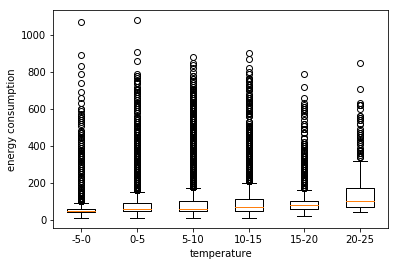

In [25]:
T_data=[]
temp=[]
for t in range(6):
    T_data.append(data.loc[(data.loc[:,'T_out']<-5+(t+1)*5)&(data.loc[:,'T_out']>-5+t*5)].loc[:,'Appliances'].reset_index(drop=True))
    temp.append('{}-{}'.format(-5+t*5,-5+(t+1)*5))
fig=plt.figure()
plt.boxplot(T_data,labels=temp)
plt.xlabel('temperature')
plt.ylabel('energy consumption')
plt.show()

Grouped by humidity

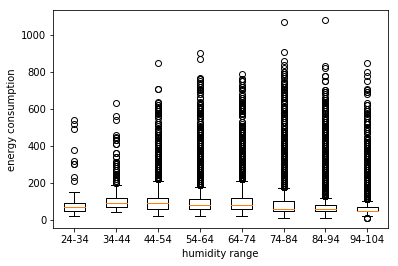

In [24]:
RH_data=[]
hum=[]
for t in range(8):
    RH_data.append(data.loc[(data.loc[:,'RH_out']<24+(t+1)*10)&(data.loc[:,'RH_out']>24+t*10)].loc[:,'Appliances'].reset_index(drop=True))
    hum.append('{}-{}'.format(24+t*10,24+(t+1)*10))
plt.figure()
plt.boxplot(RH_data,labels=hum)
plt.ylabel('energy consumption')
plt.xlabel('humidity range')
plt.show()

Grouped by day of week. Despite the intuition, the energy use doesn't differ much between workday and weekend

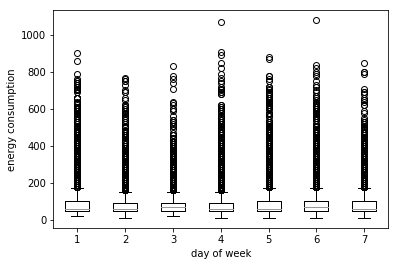

In [23]:
dayofweekdata=[]
for h in range(7):
    dayofweekdata.append(data.loc[data.loc[:,'weekday']==h].loc[:,'Appliances'].reset_index(drop=True))
plt.figure()
plt.boxplot(dayofweekdata)
plt.xlabel('day of week')
plt.ylabel('energy consumption')
plt.show()

Grouped by time in a day. It shows the most obvious pattern

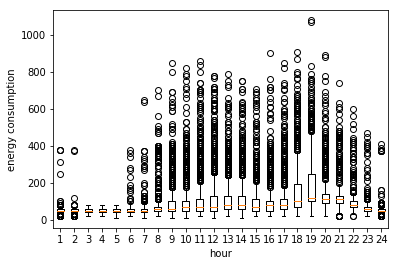

In [26]:
hourdata=[]
for h in range(24):
    hourdata.append(data.loc[(data.loc[:,'timeofday']>=60*h) & (data.loc[:,'timeofday']<60*(h+1))].loc[:,'Appliances'].reset_index(drop=True))
plt.figure()
plt.boxplot(hourdata)
plt.ylabel('energy consumption')
plt.xlabel('hour')
plt.show()

There are strong correlation between energy consumption with lights and time of day. Also note that the temperature and humidity inside the house have strong correlation with that outside (T_out, RH_out)

In [27]:
data.corr()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,timeofday,weekday
Appliances,1.000000,0.197278,0.055447,0.086031,0.120073,-0.060465,0.085060,0.036292,0.040281,0.016965,...,0.099155,-0.034885,-0.152282,0.087122,0.000230,0.015353,-0.011145,-0.011145,0.217152,0.003060
lights,0.197278,1.000000,-0.023528,0.106968,-0.005622,0.050985,-0.097393,0.131161,-0.008859,0.114936,...,-0.074424,-0.010576,0.068543,0.060281,0.020038,-0.036322,0.000521,0.000521,0.254993,-0.099828
T1,0.055447,-0.023528,1.000000,0.164006,0.836834,-0.002509,0.892402,-0.028550,0.877001,0.097861,...,0.682846,-0.150574,-0.345481,-0.087654,-0.076210,0.571309,-0.006203,-0.006203,0.178728,0.001381
RH_1,0.086031,0.106968,0.164006,1.000000,0.269839,0.797535,0.253230,0.844677,0.106180,0.880359,...,0.340767,-0.293957,0.274126,0.204932,-0.021057,0.639106,-0.000699,-0.000699,0.018531,-0.053782
T2,0.120073,-0.005622,0.836834,0.269839,1.000000,-0.165610,0.735245,0.121497,0.762066,0.231563,...,0.792255,-0.133028,-0.505291,0.052495,-0.069721,0.582602,-0.011087,-0.011087,0.254569,0.000602
RH_2,-0.060465,0.050985,-0.002509,0.797535,-0.165610,1.000000,0.137319,0.678326,-0.047304,0.721435,...,0.033674,-0.255646,0.584911,0.069190,-0.005368,0.499152,0.006275,0.006275,-0.183182,-0.044249
T3,0.085060,-0.097393,0.892402,0.253230,0.735245,0.137319,1.000000,-0.011234,0.852778,0.122737,...,0.699417,-0.189974,-0.281718,-0.100776,-0.102310,0.645886,-0.005194,-0.005194,0.037607,-0.017514
RH_3,0.036292,0.131161,-0.028550,0.844677,0.121497,0.678326,-0.011234,1.000000,-0.140457,0.898978,...,0.118207,-0.233274,0.356192,0.263188,0.017041,0.414387,-0.000477,-0.000477,-0.052343,-0.035182
T4,0.040281,-0.008859,0.877001,0.106180,0.762066,-0.047304,0.852778,-0.140457,1.000000,-0.048650,...,0.663478,-0.075292,-0.388602,-0.185747,-0.104768,0.519471,-0.001815,-0.001815,0.088334,-0.091006
RH_4,0.016965,0.114936,0.097861,0.880359,0.231563,0.721435,0.122737,0.898978,-0.048650,1.000000,...,0.293289,-0.250748,0.336813,0.300192,0.002636,0.616509,-0.001787,-0.001787,-0.019040,-0.005749


# Test of gradient boost and random forest

We shuffle the data and use 13800 of them as training data and the rest as test data. Note that though we use fixed random state seeds to shuffle data, both gradient boosting and random forest contains random procedure so the results are not exactly reproducible

In [29]:
data_shuffle=data.sample(frac=1,random_state=19891014).reset_index(drop=True)

27 features in total

In [30]:
feature=list(data.columns)
feature.remove('rv1')
feature.remove('rv2')
feature.remove('date')
feature.remove('Appliances')
feature

['lights',
 'T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint',
 'timeofday',
 'weekday']

In [31]:
xtrain=np.array(data_shuffle.loc[:13800,feature]).copy(order='C')
ytrain=np.array(data_shuffle.loc[:13800,'Appliances']).copy(order='C')
xtest=np.array(data_shuffle.loc[13801:,feature]).copy(order='C')
ytest=np.array(data_shuffle.loc[13801:,'Appliances']).copy(order='C')

A multi-linear regression model for benchmark, of course both random forest and gradient boost will beat it

In [33]:
lm=sklearn.linear_model.Ridge()
lm.fit(xtrain,ytrain)
yhat=lm.predict(xtest)
print('multi-linear regression model yields R^2={} and MSE={}'.format(lm.score(xtest,ytest),np.mean(np.power(yhat-ytest,2))))

multi-linear regression model yields R^2=0.16667708657350844 and MSE=8877.953460850302


# Gradient boost: Shrinkage

We change the shrinkage rate of gradient boost (also called learning rate). It is the equivalent of step length in gradient descent, which shrinks the length of move even if we know that direction will reduce target function. 

We see that a learning rate 1 will cause severe overfit. A learning rate of 0.1 slowly but steadily improves the result even after 4000 iteration. A learning rate of 0.5 will not overfit badly but reaches a ceiling after about 2000 iterations.

The result also shows the great power of gradient boost in picking up the signal (and noise) of target value as it can achieve R^2 close to 1 on training data if uncontrolled. Thus the necessity of regularization.

In [104]:
N_ran=[i*100 for i in range(1,31)]
sk=[0.1,0.5,1]
testscore=[[0 for i in range(len(N_ran))]for j in range(len(sk))]
testmse=[[0 for i in range(len(N_ran))] for j in range(len(sk))]
trainscore=[[0 for i in range(len(N_ran))]for j in range(len(sk))]
trainmse=[[0 for i in range(len(N_ran))] for j in range(len(sk))]
for s in range(len(sk)):
    gb=sklearn.ensemble.GradientBoostingRegressor(learning_rate=sk[s],max_features=5,max_leaf_nodes=15,warm_start=True)
    for N in range(len(N_ran)):
        gb.set_params(n_estimators=N_ran[N])
        gb.fit(xtrain,ytrain)
        testscore[s][N]=gb.score(xtest,ytest)
        testmse[s][N]=gb.loss_(ytest,gb.predict(xtest))
        trainscore[s][N]=gb.score(xtrain,ytrain)
        trainmse[s][N]=gb.loss_(ytrain,gb.predict(xtrain))

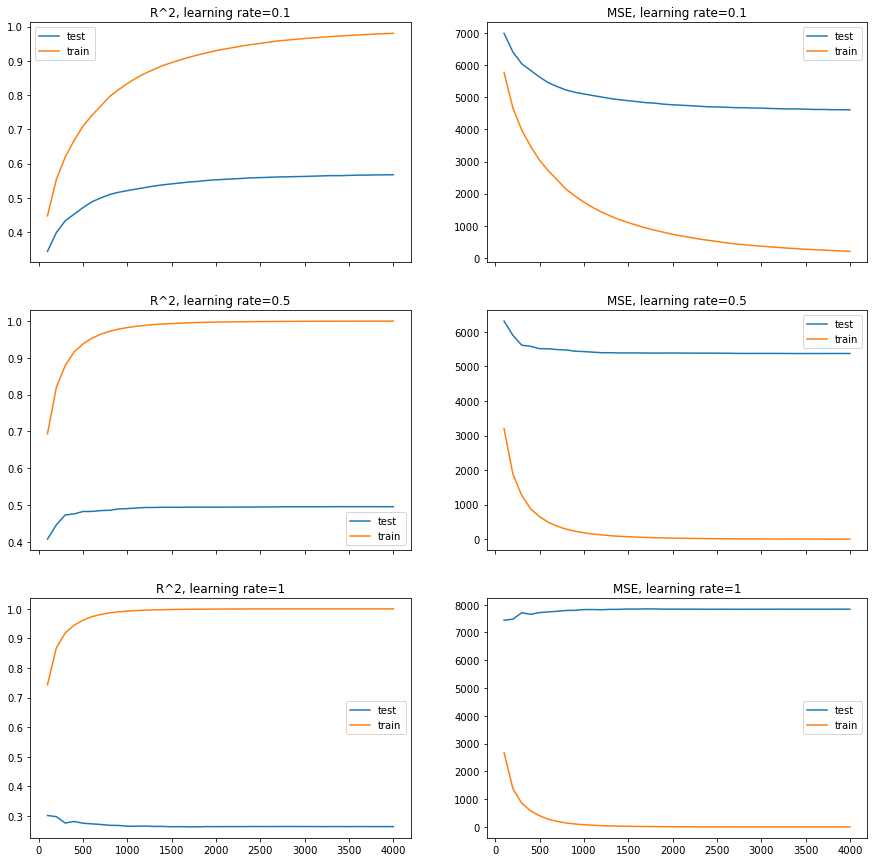

In [105]:
plt.figure()
f,plots=plt.subplots(3,2,sharex=True,figsize=(15,15))
for s in range(len(sk)):
    p1,=plots[s,0].plot(N_ran,testscore[s])
    p2,=plots[s,0].plot(N_ran,trainscore[s])
    plots[s,0].legend([p1,p2],["test","train"])
    plots[s,0].set_title("R^2, learning rate={}".format(sk[s]))
    p1,=plots[s,1].plot(N_ran,testmse[s])
    p2,=plots[s,1].plot(N_ran,trainmse[s])
    plots[s,1].legend([p1,p2],["test","train"])
    plots[s,1].set_title("MSE, learning rate={}".format(sk[s]))
plt.show()

# Gradient boost: Feature number

By feature number we mean the number of random features we choose form which we will split the tree nodes. It doesn't have too much impact on the result. Big feature number even causes a little downgrade in performance

In [106]:
N_ran=[i*100 for i in range(1,51)]
feature_ran=[5,10,15]
testscore=[[0 for i in range(len(N_ran))]for j in range(len(feature_ran))]
testmse=[[0 for i in range(len(N_ran))] for j in range(len(feature_ran))]
for f in range(len(feature_ran)):
    gb=sklearn.ensemble.GradientBoostingRegressor(max_features=feature_ran[f],max_leaf_nodes=15,warm_start=True)
    for N in range(len(N_ran)):
        gb.set_params(n_estimators=N_ran[N])
        gb.fit(xtrain,ytrain)
        testscore[f][N]=gb.score(xtest,ytest)
        testmse[f][N]=gb.loss_(ytest,gb.predict(xtest))

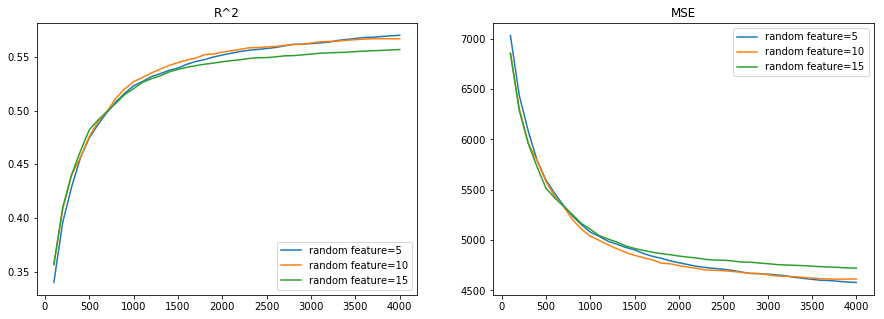

In [107]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,5))
p1,=plots[0].plot(N_ran,testscore[0])
p2,=plots[0].plot(N_ran,testscore[1])
p3,=plots[0].plot(N_ran,testscore[2])
plots[0].legend([p1,p2,p3],["random feature={}".format(feature_ran[0]),"random feature={}".format(feature_ran[1]),"random feature={}".format(feature_ran[2])])
plots[0].set_title('R^2')
p1,=plots[1].plot(N_ran,testmse[0])
p2,=plots[1].plot(N_ran,testmse[1])
p3,=plots[1].plot(N_ran,testmse[2])
plots[1].legend([p1,p2,p3],["random feature={}".format(feature_ran[0]),"random feature={}".format(feature_ran[1]),"random feature={}".format(feature_ran[2])])
plots[1].set_title('MSE')
plt.show()

# Gradient boost: Maximum nodes

The maximum nodes allowed in each tree.

 We see that below 15, adding the number of nodes has effect on improving the model, but after that it will become over fit.

In [109]:
N_ran=[i*100 for i in range(1,51)]
leaf_node_ran=[5,15,30]
testscore=[[0 for i in range(len(N_ran))] for j in range(len(leaf_node_ran))]
testmse=[[0 for i in range(len(N_ran))] for j in range(len(leaf_node_ran))]
for ln in range(len(leaf_node_ran)):
    gb=sklearn.ensemble.GradientBoostingRegressor(max_features=5,max_leaf_nodes=leaf_node_ran[ln],warm_start=True)
    for N in range(len(N_ran)):
        gb.set_params(n_estimators=N_ran[N])
        gb.fit(xtrain,ytrain)
        testscore[ln][N]=gb.score(xtest,ytest)
        testmse[ln][N]=gb.loss_(ytest,gb.predict(xtest))

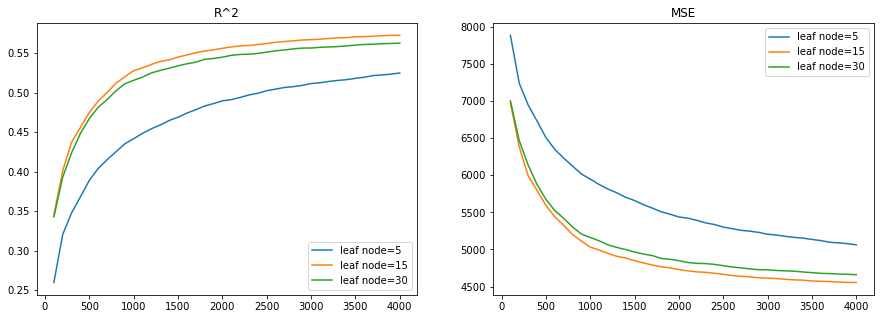

In [110]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,5))
p1,=plots[0].plot(N_ran,testscore[0])
p2,=plots[0].plot(N_ran,testscore[1])
p3,=plots[0].plot(N_ran,testscore[2])
legendcontent=["leaf node={}".format(leaf_node_ran[i]) for i in range(len(leaf_node_ran))]
plots[0].legend([p1,p2,p3],legendcontent)
plots[0].set_title('R^2')
p1,=plots[1].plot(N_ran,testmse[0])
p2,=plots[1].plot(N_ran,testmse[1])
p3,=plots[1].plot(N_ran,testmse[2])
plots[1].legend([p1,p2,p3],legendcontent)
plots[1].set_title('MSE')
plt.show()

# Random forest: Feature number

Unlike gradient boost, random forest result keeps improving as we add more features

In [119]:
N_ran=[i*20 for i in range(1,51)]
feature_ran=[5,15,20]
testscore=[[0 for i in range(len(N_ran))]for j in range(len(feature_ran))]
testmse=[[0 for i in range(len(N_ran))] for j in range(len(feature_ran))]
for f in range(len(feature_ran)):
    rf=sklearn.ensemble.RandomForestRegressor(warm_start=True,max_features=feature_ran[f],max_leaf_nodes=20)
    for N in range(len(N_ran)):
        rf.set_params(n_estimators=N_ran[N])
        rf.fit(xtrain,ytrain)
        testscore[f][N]=rf.score(xtest,ytest)
        yhat=rf.predict(xtest)
        testmse[f][N]=np.mean(np.power(yhat-ytest,2))

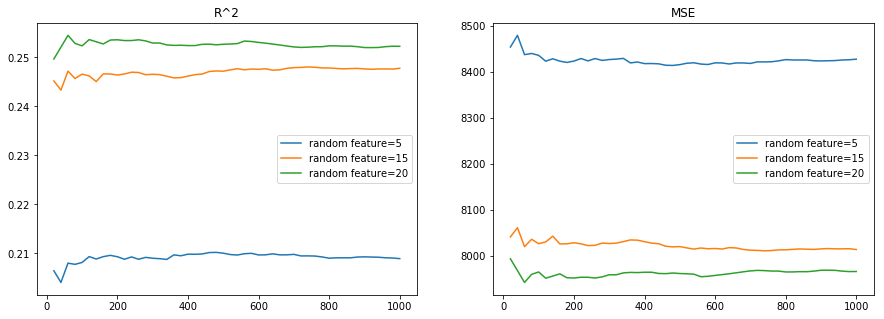

In [120]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,5))
p1,=plots[0].plot(N_ran,testscore[0])
p2,=plots[0].plot(N_ran,testscore[1])
p3,=plots[0].plot(N_ran,testscore[2])
plots[0].legend([p1,p2,p3],["random feature={}".format(feature_ran[0]),"random feature={}".format(feature_ran[1]),"random feature={}".format(feature_ran[2])])
plots[0].set_title('R^2')
p1,=plots[1].plot(N_ran,testmse[0])
p2,=plots[1].plot(N_ran,testmse[1])
p3,=plots[1].plot(N_ran,testmse[2])
plots[1].legend([p1,p2,p3],["random feature={}".format(feature_ran[0]),"random feature={}".format(feature_ran[1]),"random feature={}".format(feature_ran[2])])
plots[1].set_title('MSE')
plt.show()

# Random forest: Maximum nodes

The shiniest part of random forest. It still improves when we allow 200 nodes, when gradient boost would have already died of overfitting. The best result is when we remove the bound for maximum nodes. This is because random forest used the average of a collection of trees on bootstrapped data, and the noise picked up by a single tree will be average in prediction.

Another observation is that unlike gradient boost, random forest's result doesn't improve after 500 iterations. This is not a surprise because more trees in RF only serve to reduce variance, not bias.

In [117]:
N_ran=[i*10 for i in range(1,41)]
leaf_node_ran=[100,200,None]
testscore=[[0 for i in range(len(N_ran))] for j in range(len(leaf_node_ran))]
testmse=[[0 for i in range(len(N_ran))] for j in range(len(leaf_node_ran))]
for ln in range(len(leaf_node_ran)):
    rf=sklearn.ensemble.RandomForestRegressor(warm_start=True,max_features=20,max_leaf_nodes=leaf_node_ran[ln])
    for N in range(len(N_ran)):
        rf.set_params(n_estimators=N_ran[N])
        rf.fit(xtrain,ytrain)
        testscore[ln][N]=rf.score(xtest,ytest)
        yhat=rf.predict(xtest)
        testmse[ln][N]=np.mean(np.power(yhat-ytest,2))

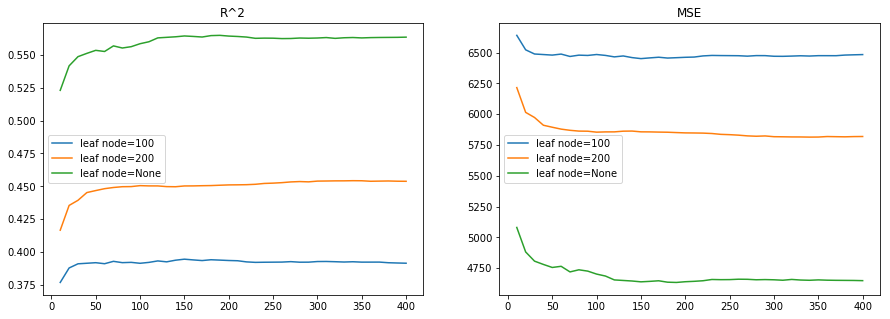

In [118]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,5))
p1,=plots[0].plot(N_ran,testscore[0])
p2,=plots[0].plot(N_ran,testscore[1])
p3,=plots[0].plot(N_ran,testscore[2])
plots[0].legend([p1,p2,p3],["leaf node={}".format(leaf_node_ran[0]),"leaf node={}".format(leaf_node_ran[1]),"leaf node=unlimited"])
plots[0].set_title('R^2')
p1,=plots[1].plot(N_ran,testmse[0])
p2,=plots[1].plot(N_ran,testmse[1])
p3,=plots[1].plot(N_ran,testmse[2])
plots[1].legend([p1,p2,p3],["leaf node={}".format(leaf_node_ran[0]),"leaf node={}".format(leaf_node_ran[1]),"leaf node=unlimited"])
plots[1].set_title('MSE')
plt.show()

To summarize our observations

# Gradient boost: surpress the impact of each tree, approach target slowly

# Random forest: maximize the efficiency of each tree, use number to fight overfit

To compare them, we choose from above investigation, the optimize parameters for each method. For gradient descent we choose learning rate=0.1 random features number 5 and maximum leaf nodes 15. For random forest, random feature number 20 and no limit for maximum leaf nodes.

In [35]:
N_ran_rf=[i*20 for i in range(1,51)]
testscore_rf=[0 for i in range(len(N_ran_rf))]
testmse_rf=[0 for i in range(len(N_ran_rf))]
N_ran_gb=[i*100 for i in range(1,51)]
testscore_gb=[0 for i in range(len(N_ran_gb))]
testmse_gb=[0 for i in range(len(N_ran_gb))]
rf=sklearn.ensemble.RandomForestRegressor(warm_start=True,max_features=20)
gb=sklearn.ensemble.GradientBoostingRegressor(warm_start=True,max_features=5,max_leaf_nodes=15)
for N in range(len(N_ran_rf)):
    rf.set_params(n_estimators=N_ran_rf[N])
    rf.fit(xtrain,ytrain)
    testscore_rf[N]=rf.score(xtest,ytest)
    yhat=rf.predict(xtest)
    testmse_rf[N]=np.mean(np.power(yhat-ytest,2))
for N in range(len(N_ran_gb)):
    gb.set_params(n_estimators=N_ran_gb[N])
    gb.fit(xtrain,ytrain)
    testscore_gb[N]=gb.score(xtest,ytest)
    yhat=gb.predict(xtest)
    testmse_gb[N]=np.mean(np.power(yhat-ytest,2))

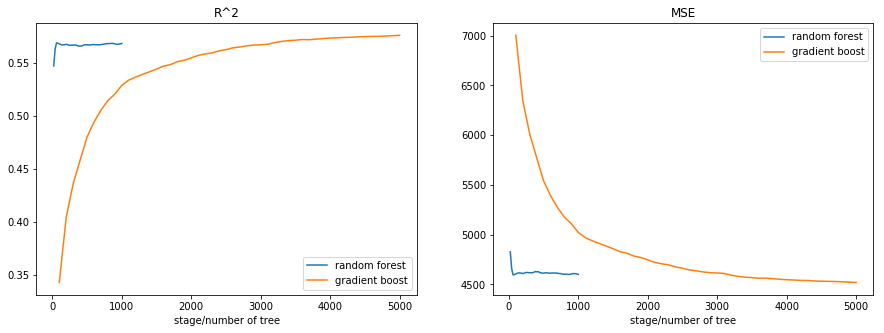

In [42]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,5))
p1,=plots[0].plot(N_ran_rf,testscore_rf)
p2,=plots[0].plot(N_ran_gb,testscore_gb)
plots[0].legend([p1,p2],["random forest","gradient boost"])
plots[0].set_title('R^2')
plots[0].set_xlabel('stage or number of tree')
p1,=plots[1].plot(N_ran_rf,testmse_rf)
p2,=plots[1].plot(N_ran_gb,testmse_gb)
plots[1].legend([p1,p2],["random forest","gradient boost"])
plots[1].set_title('MSE')
plots[1].set_xlabel('stage or number of tree')
plt.show()

The comparison of final result

In [47]:
gb=sklearn.ensemble.GradientBoostingRegressor(n_estimators=5000,max_features=5,max_leaf_nodes=15)
t1=time()
gb.fit(xtrain,ytrain)
t2=time()

In [48]:
yhat=gb.predict(xtest)
print('Gradient boost model yields R^2={} and MSE={}, used {} seconds'.format(gb.score(xtest,ytest),np.mean(np.power(yhat-ytest,2)),t2-t1))

Gradient boost model yields R^2=0.57543462801083 and MSE=4523.182493698392, used 31.25537610054016


In [49]:
rf=sklearn.ensemble.RandomForestRegressor(n_estimators=500,max_features=20)
t1=time()
rf.fit(xtrain,ytrain)
t2=time()

In [50]:
yhat=rf.predict(xtest)
print('Random forest model yields R^2={} and MSE={}, used {} seconds'.format(rf.score(xtest,ytest),np.mean(np.power(yhat-ytest,2)),t2-t1))

Random forest model yields R^2=0.5638762320683824 and MSE=4646.321914930907, used 94.27034950256348 seconds


The gradient boost wins in every front. In http://www.sciencedirect.com/science/article/pii/S0378778816308970?via%3Dihub, the provider of the data did a similar investigation. They also conclude that gradient boost gives the best result (R^2=0.57 and RMSE=66.65), our result agrees with them. They report the random forest's best result as R^2=0.54 and RMSE=68.48 which is slight worse than what we acheived.

The most shocking fact is that while both models are not that far away from each other in terms of prediction scores. They view the status of features quite differently.

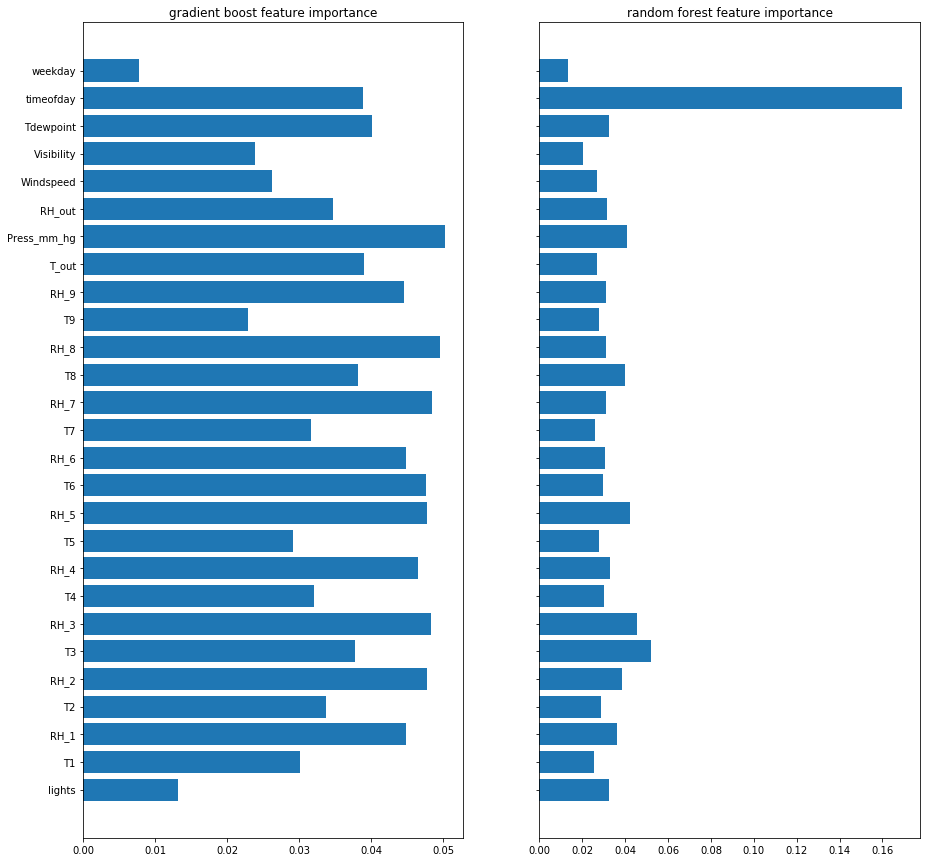

In [51]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,15),sharey=True)
plots[0].barh(np.arange(len(feature)),gb.feature_importances_)
plots[0].set_title('gradient boost feature importance')
plots[1].barh(np.arange(len(feature)),rf.feature_importances_)
plots[1].set_title('random forest feature importance')
plt.yticks(np.arange(len(feature)),feature)
plt.show()

Another curiosity is that both model produces residue with a long negative tail, that is, they both prefer extremely smaller results over extremely greater results.

In [53]:
yhat_gb=gb.predict(xtest)
res_gb=yhat_gb-ytest
yhat_rf=rf.predict(xtest)
res_rf=yhat_rf-ytest

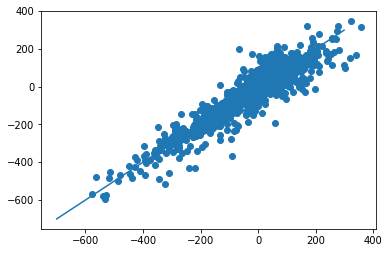

In [54]:
plt.figure()
plt.scatter(res_gb,res_rf)
plt.plot(range(-700,300),range(-700,300))
plt.show()

# A combinational model?

We find that if we take the weighted average of prediction from both model, we would get a better result on the test data than both model

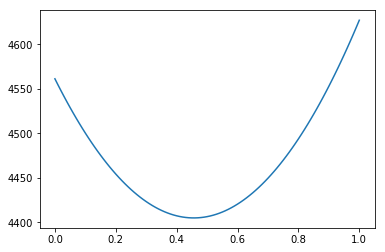

In [137]:
x_ran=[i*0.01 for i in range(101)]
combined_model=[np.mean(np.power(yhat_rf*x+yhat_gb*(1-x)-ytest,2)) for x in x_ran]
plt.figure()
plt.plot(x_ran,combined_model)
plt.xlabel('random forest weight')
plt.title('MSE of weighted average of prediction from both model')
plt.show()

In order to make sure we are not overfitting the weight on the test data, we split the data into three parts. We fit the model on training data, select the best weight on validation data and test on test data.

In [55]:
xtrain=np.array(data_shuffle.loc[:7000,feature]).copy(order='C')
ytrain=np.array(data_shuffle.loc[:7000,'Appliances']).copy(order='C')
xvalidate=np.array(data_shuffle.loc[7001:14000,feature]).copy(order='C')
yvalidate=np.array(data_shuffle.loc[7001:14000,'Appliances']).copy(order='C')
xtest=np.array(data_shuffle.loc[14001:,feature]).copy(order='C')
ytest=np.array(data_shuffle.loc[14001:,'Appliances']).copy(order='C')

In [56]:
gb.fit(xtrain,ytrain)
rf.fit(xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [71]:
yhat_gb=gb.predict(xvalidate)
yhat_rf=rf.predict(xvalidate)

The optimized weight is 0.48

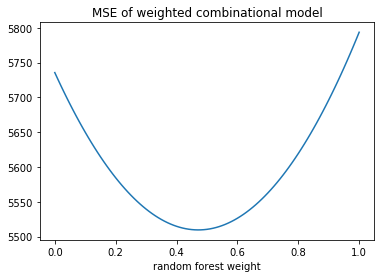

In [72]:
x_ran=[i*0.01 for i in range(101)]
combined_model=[np.mean(np.power(yhat_rf*x+yhat_gb*(1-x)-yvalidate,2)) for x in x_ran]
plt.figure()
plt.plot(x_ran,combined_model)
plt.xlabel('random forest weight')
plt.title('MSE of weighted combinational model')
plt.show()

We see that if we apply this combinational model on test data set, 0.48 wouldn't be the best parameter, but still gives better result than either single model

In [67]:
yhat_gb=gb.predict(xtest)
yhat_rf=rf.predict(xtest)

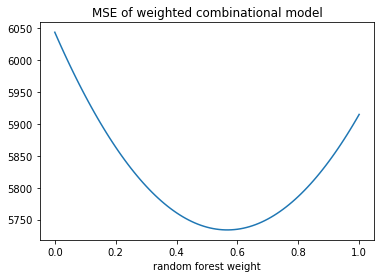

In [69]:
x_ran=[i*0.01 for i in range(101)]
combined_model=[np.mean(np.power(yhat_rf*x+yhat_gb*(1-x)-ytest,2)) for x in x_ran]
plt.figure()
plt.plot(x_ran,combined_model)
plt.xlabel('random forest weight')
plt.title('MSE of weighted combinational model')
plt.show()